In [1]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


manualSeed = 999

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else 'cpu')


In [3]:
dataroot ='./t_data'

workers = 2

batch_size = 1

image_size = 128

nc = 1

nz =100

ngf = 64

ndf = 64

num_epochs = 30

lr = 2e-4

beta1 = 0.5

ngpu = 1

In [4]:
dataroot

'./t_data'

In [5]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5]),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input Z
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//2),
            nn.ReLU(True),
            # (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf//2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input (nc) x 64 x 64
            nn.Conv2d(nc, ndf//2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf//2, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))


netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, 

In [11]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(1, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
img_list = []
G_losses = []
D_losses = []
iters = 0
gan_loss = np.Inf
d_loss = np.Inf

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)

        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()


        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        if errG.item() <= gan_loss and errD.item()<=d_loss:
            print('gan loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(gan_loss, errG.item()))
            print('d loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(d_loss, errD.item()))
            
            torch.save(netG.state_dict(), 'model_gan.pt')
            gan_loss = errG.item()
            d_loss = errD.item()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/30][0/700]	Loss_D: 2.7796	Loss_G: 21.4290	D(x): 0.5094	D(G(z)): 0.8782 / 0.0000
gan loss decreased (inf --> 21.429001).  Saving model ...
d loss decreased (inf --> 2.779611).  Saving model ...
gan loss decreased (21.429001 --> 7.780325).  Saving model ...
d loss decreased (2.779611 --> 0.034454).  Saving model ...


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


gan loss decreased (7.780325 --> 6.349285).  Saving model ...
d loss decreased (0.034454 --> 0.003675).  Saving model ...
[0/30][50/700]	Loss_D: 0.0013	Loss_G: 7.4884	D(x): 1.0000	D(G(z)): 0.0013 / 0.0006
gan loss decreased (6.349285 --> 0.241352).  Saving model ...
d loss decreased (0.003675 --> 0.002452).  Saving model ...
[0/30][100/700]	Loss_D: 0.0036	Loss_G: 19.6332	D(x): 0.9965	D(G(z)): 0.0000 / 0.0000
[0/30][150/700]	Loss_D: 1.1519	Loss_G: 23.5861	D(x): 0.9990	D(G(z)): 0.6836 / 0.0000
[0/30][200/700]	Loss_D: 0.0030	Loss_G: 7.6074	D(x): 0.9990	D(G(z)): 0.0020 / 0.0005
[0/30][250/700]	Loss_D: 0.1471	Loss_G: 3.2922	D(x): 0.9530	D(G(z)): 0.0942 / 0.0372
[0/30][300/700]	Loss_D: 0.0141	Loss_G: 5.3362	D(x): 0.9965	D(G(z)): 0.0105 / 0.0048
[0/30][350/700]	Loss_D: 0.1605	Loss_G: 4.1662	D(x): 1.0000	D(G(z)): 0.1483 / 0.0155
[0/30][400/700]	Loss_D: 0.0123	Loss_G: 4.8750	D(x): 0.9988	D(G(z)): 0.0110 / 0.0076
[0/30][450/700]	Loss_D: 1.7706	Loss_G: 1.5893	D(x): 0.1722	D(G(z)): 0.0111 / 0.2041

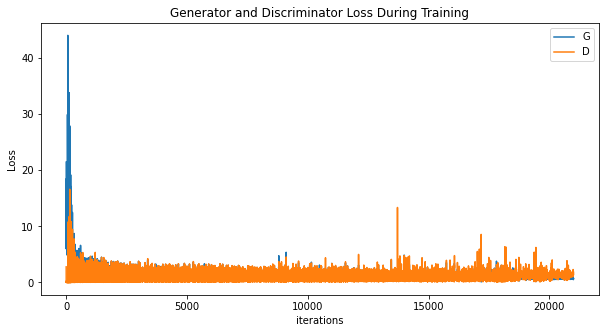

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
img_list[1].shape

torch.Size([3, 128, 128])

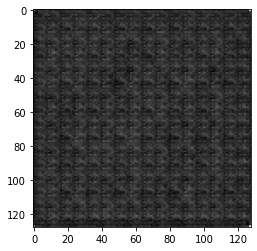

In [15]:
plt.imshow(img_list[1].permute(1,2,0))

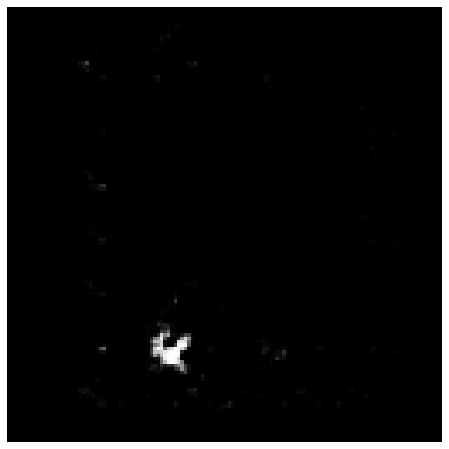

In [17]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [26]:
fake=netG(torch.randn(1, nz, 1, 1, device=device))
aa = torch.squeeze(torch.squeeze(fake,dim=0)).to('cpu').detach().numpy()

In [28]:
fake = torch.squeeze(torch.squeeze(fake,dim=0)).to('cpu').detach().numpy()

In [31]:
np.unique(fake)

array([-1.        , -0.99999994, -0.9999999 , ...,  0.9999929 ,
        0.99999315,  0.9999965 ], dtype=float32)

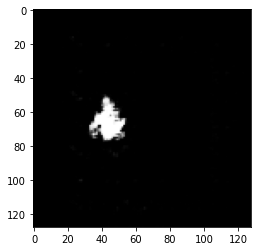

In [32]:
plt.imshow(fake,cmap='gray')

In [33]:
np.unique(fake>0)

array([False,  True])

In [34]:
b=np.where(fake>0)
c=np.where(fake<0)

In [35]:
fake[b] = 255
fake[c] = 0

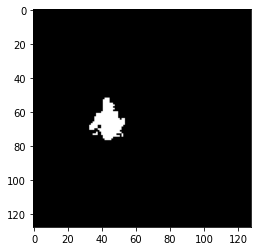

In [36]:
plt.imshow(fake, cmap='gray')